# Results, section 2:

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import get_fdr_p_df

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude'
extra_str = '_consist' # '_vol_norm' '_noboxcox'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_scale = 200
primary_covariate = 'ageAtScan1_Years'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, train_test_str = train_test_str,
                                                                                        parc_scale = parc_scale, primary_covariate = primary_covariate,
                                                                                       extra_str = extra_str, edge_weight = edge_weight)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis_cubic/normative/t1Exclude/squeakycleanExclude/schaefer_200_streamlineCount_consist/ageAtScan1_Years+sex_adj'

In [5]:
metrics = ['vol', 'str', 'ac', 'mc']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']

In [6]:
# metrics = ('vol', 'str', 'ac', 'mc')
# metrics = ('vol', 'str')
# metrics = ('ac',)

# phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
#          'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
#           'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency')


# phenos = ('F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
#           'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency')

# phenos = ('Overall_Psychopathology', 'F3_Executive_Efficiency')

## Setup plots

In [7]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = sns.color_palette("pastel", 3)

## Load data

In [8]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)

# Test
df_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True); print(df_test.shape)
df_node_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True); print(df_node_test.shape)

(304, 47)
(758, 47)
(758, 800)


In [9]:
z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns); print(df_z.shape)

(758, 800)


In [10]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node_test.columns)

smse_thresh = 1
region_filter = df_smse.iloc[:,0] < smse_thresh
print(region_filter.sum())

611


In [11]:
# Forward model
synth_cov_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'forward/synth_cov_test.txt'),
                             delim_whitespace = True, names=[primary_covariate, 'sex_adj'])

yhat_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/yhat.txt'), delimiter = ' ').transpose()
df_yhat_forward = pd.DataFrame(data = yhat_forward, index = synth_cov_test.index, columns = df_node_test.columns)

In [12]:
# at each roi, the differences between first and last age point in the synthetic data
# for each node/metric, a negative value means that the nm predicted an overall decrease in y with age (i.e, a negative function),
# while a positive values means that the nm predicted an overall increase in y with age (i.e., a positive function)
df_yhat_tmp1 = df_yhat_forward[synth_cov_test['sex_adj'] == 0].iloc[-1,:] - df_yhat_forward[synth_cov_test['sex_adj'] == 0].iloc[0,:]
df_yhat_tmp2 = df_yhat_forward[synth_cov_test['sex_adj'] == 1].iloc[-1,:] - df_yhat_forward[synth_cov_test['sex_adj'] == 1].iloc[0,:]
df_yhat_diff = pd.concat((df_yhat_tmp1, df_yhat_tmp2), axis = 1)

x = df_yhat_tmp1 > 0
y = df_yhat_tmp2 > 0
print(np.sum(x == y))

# boolean that designates which regions carry with positive predicted change.
# nm_is_pos = df_yhat_diff[0] > 0
nm_is_pos = np.logical_and(x,y)
print(np.sum(nm_is_pos))

# flipping the z-stats in these regions has the effect of standardising their interpration across the brain to be inline
# with the negative predicted change statement above
df_z.loc[:,nm_is_pos] = df_z.loc[:,nm_is_pos] * -1

790
308


In [13]:
my_bool = df_train.loc[:,phenos].isna().any(axis = 1)
df_train = df_train.loc[~my_bool,:]
print('N:', df_train.shape[0])

my_bool = df_test.loc[:,phenos].isna().any(axis = 1)
df_test = df_test.loc[~my_bool,:]
df_z = df_z.loc[~my_bool,:]

print('N:', df_test.shape[0])

N: 304
N: 758


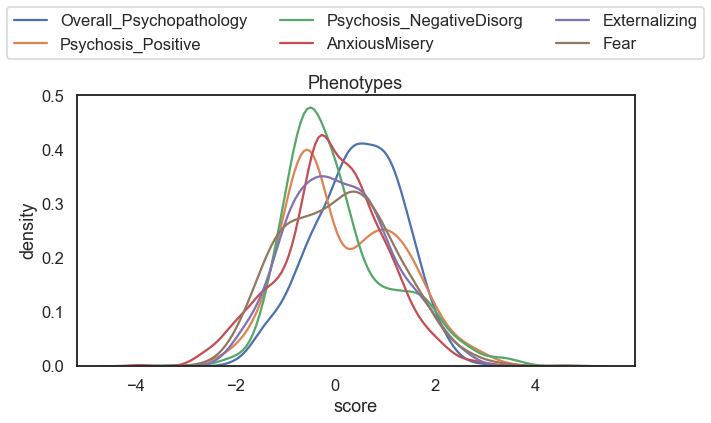

In [14]:
f, axes = plt.subplots()
f.set_figwidth(10)
f.set_figheight(5)
axes.set_title('Phenotypes')

for i, pheno in enumerate(phenos):
    sns.kdeplot(df_test.loc[:,pheno], ax = axes, label = pheno)
    axes.set_ylabel('density')
    axes.set_xlabel('score')
    axes.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)

### Normalize phenotypes

In [15]:
# for pheno in phenos:
#     df_test.loc[:,pheno] = sp.stats.yeojohnson(df_test.loc[:,pheno])[0]

In [16]:
# f, axes = plt.subplots()
# f.set_figwidth(10)
# f.set_figheight(5)
# axes.set_title('Phenotypes')

# for i, pheno in enumerate(phenos):
#     sns.kdeplot(df_test.loc[:,pheno], ax = axes, label = pheno)
#     axes.set_ylabel('density')
#     axes.set_xlabel('score')
#     axes.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)

### Regress age/sex out of psychopathology phenotypes

In [17]:
covs = [primary_covariate, 'sex_adj', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']

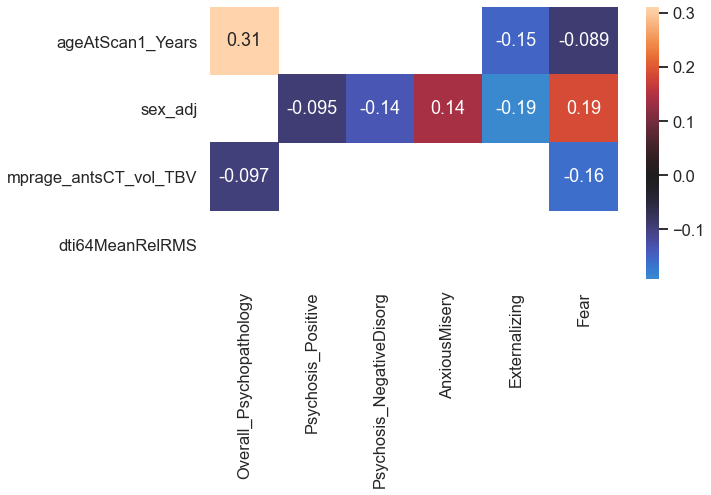

In [18]:
r = pd.DataFrame(index = covs, columns = phenos)
p = pd.DataFrame(index = covs, columns = phenos)

for cov in covs:
    for pheno in phenos:
        r.loc[cov,pheno] = sp.stats.pearsonr(df_test.loc[:,cov], df_test.loc[:,pheno])[0]
        p.loc[cov,pheno] = sp.stats.pearsonr(df_test.loc[:,cov], df_test.loc[:,pheno])[1]

f, ax = plt.subplots(1)
f.set_figwidth(10)
f.set_figheight(5)

p = get_fdr_p_df(p)

sns.heatmap(r[p<.05].astype(float), annot = True, center = 0, ax = ax, square = True)

In [19]:
# fit nuisance regression on the train data
df_nuis_train = df_train.loc[:,covs]
df_nuis_train = sm.add_constant(df_nuis_train)
mdl = sm.OLS(df_train.loc[:,phenos], df_nuis_train).fit()

# use regression coefficients from training set to residualize DVs in test set
df_nuis_test = df_test.loc[:,covs]
df_nuis_test = sm.add_constant(df_nuis_test)
y_pred = mdl.predict(df_nuis_test)
y_pred.columns = phenos
df_test.loc[:,phenos] = df_test.loc[:,phenos] - y_pred

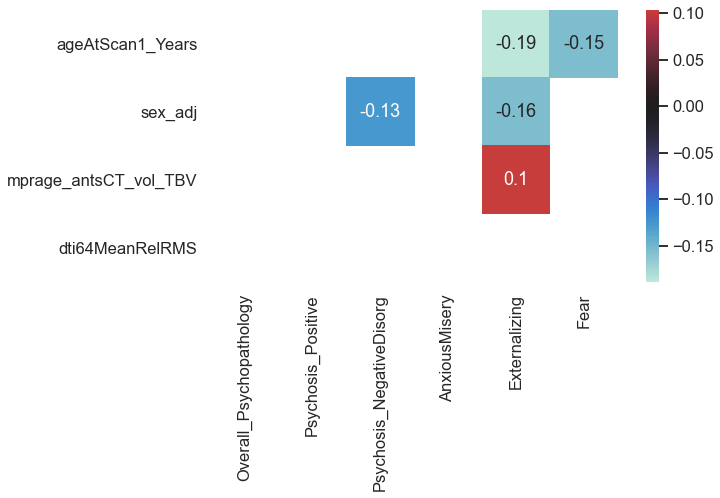

In [20]:
r = pd.DataFrame(index = covs, columns = phenos)
p = pd.DataFrame(index = covs, columns = phenos)

for cov in covs:
    for pheno in phenos:
        r.loc[cov,pheno] = sp.stats.pearsonr(df_test.loc[:,cov], df_test.loc[:,pheno])[0]
        p.loc[cov,pheno] = sp.stats.pearsonr(df_test.loc[:,cov], df_test.loc[:,pheno])[1]

f, ax = plt.subplots(1)
f.set_figwidth(10)
f.set_figheight(5)

p = get_fdr_p_df(p)

sns.heatmap(r[p<.05].astype(float), annot = True, center = 0, ax = ax, square = True)

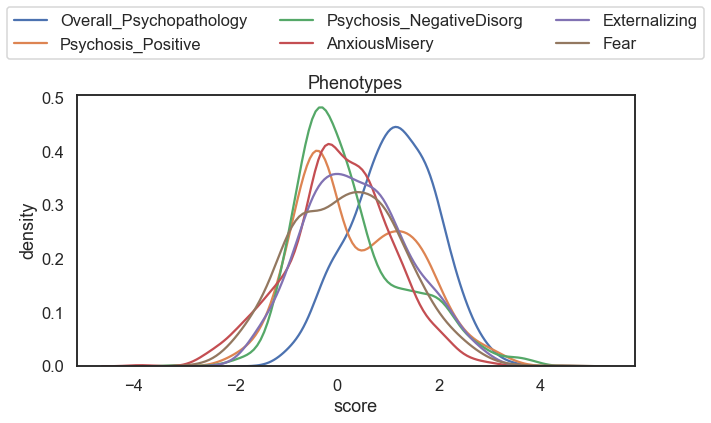

In [21]:
f, axes = plt.subplots()
f.set_figwidth(10)
f.set_figheight(5)
axes.set_title('Phenotypes')

for i, pheno in enumerate(phenos):
    sns.kdeplot(df_test.loc[:,pheno], ax = axes, label = pheno)
    axes.set_ylabel('density')
    axes.set_xlabel('score')
    axes.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)

## Export

In [20]:
# Create subdirectory for specific normative model -- labeled according to parcellation/resolution choices and covariates
outdir = os.path.join(os.environ['NORMATIVEDIR'], 'predict_pheno_signflip')
print(outdir)
if not os.path.exists(outdir): os.mkdir(outdir);

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis_cubic/normative/t1Exclude/squeakycleanExclude/schaefer_200_streamlineCount_consist/ageAtScan1_Years+sex_adj/predict_pheno_signflip


In [21]:
my_str = '|'.join(metrics)
my_str

'vol|str|ac|mc'

In [22]:
# df_z.loc[:,region_filter].filter(regex = my_str).to_csv(os.path.join(outdir, 'X.csv'))
df_z.filter(regex = my_str).to_csv(os.path.join(outdir, 'X.csv'))
df_test.loc[:,phenos].to_csv(os.path.join(outdir, 'y.csv'))